In [1]:
import sys
import os

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

sys.path.insert(0, '../')
from few.trajectory.flux import RunSchwarzEccFluxInspiral
from few.amplitude.romannet import ROMANAmplitude

## Trajectory Module

In [67]:
traj = RunSchwarzEccFluxInspiral()

In [3]:
M = 1e5
mu = 1e1
p0 = 10.0
e0 = 0.7

for i in range(20):
    t, p, e, Phi_phi, Phi_r, flux = traj(M, mu, p0, e0)

Text(0, 0.5, 'e')

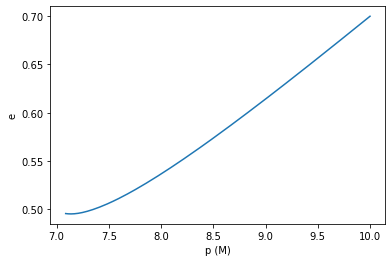

In [4]:
plt.plot(p, e)
plt.xlabel('p (M)')
plt.ylabel('e')

### Defining a new t vector

/Users/michaelkatz/anaconda3/envs/few_env/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


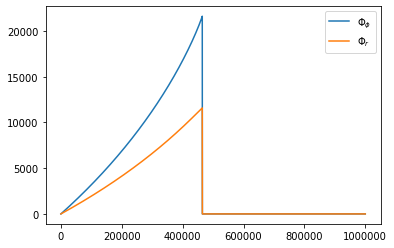

In [5]:
new_t = np.arange(0, 1e6, 1.0) 
t, p, e, Phi_phi, Phi_r, flux = traj(M, mu, p0, e0, new_t=new_t, upsample=True)

plt.plot(t, Phi_phi, label=r'$\Phi_\phi$')
plt.plot(t, Phi_r, label=r'$\Phi_r$')
plt.legend()

### Defining dt and T

/Users/michaelkatz/anaconda3/envs/few_env/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


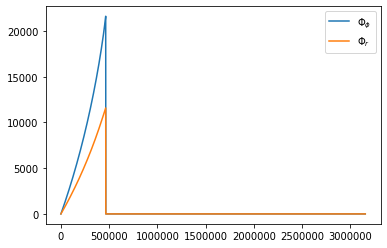

In [8]:
dt = 15.0
T = 0.1 # years
t, p, e, Phi_phi, Phi_r, flux = traj(M, mu, p0, e0, dt=dt, T=T, upsample=True)

plt.plot(t, Phi_phi, label=r'$\Phi_\phi$')
plt.plot(t, Phi_r, label=r'$\Phi_r$')
plt.legend()

## Amplitude Module

In [2]:
amp = ROMANAmplitude()

In [ ]:
p = np.linspace(10.0, 14.0)
e = np.linspace(0.1, 0.7)

p_all, e_all = np.asarray([temp.ravel() for temp in np.meshgrid(p, e)])
print(p_all.shape)
for i in range(20):
    teuk_modes = amp(p_all, e_all)
    print(i)
cb = plt.contourf(p, e, teuk_modes[:, 0].reshape(len(p), len(e)))
plt.colorbar(cb)
plt.xlabel('p (M)')
plt.ylabel('e')

(2500,)
0
1
2
3
4
5
6
7
8
9
10
11
12


In [84]:
wave0 = np.genfromtxt('../slow_1e6_1e1_10_07.txt')[:-2]
t = wave0[:, 0]
wave0 = wave0[:, 5] + wave0[:, 6]*1j
wave1 = np.load('../fast_1e6_1e1_10_07.npy')

In [18]:
wave0.shape, wave1.shape

((3287250,), (3287250,))

In [31]:
int(wave0.shape[0]/2) - int(num_pts/2)

1643125

In [30]:
np.array([0, int(wave0.shape[0]/2) - int(num_pts/2), wave0[0] - num_pts])

array([ 0.00000000e+00+0.0000000e+00j,  1.64312500e+06+0.0000000e+00j,
       -9.99806143e+02-5.9526243e-17j])

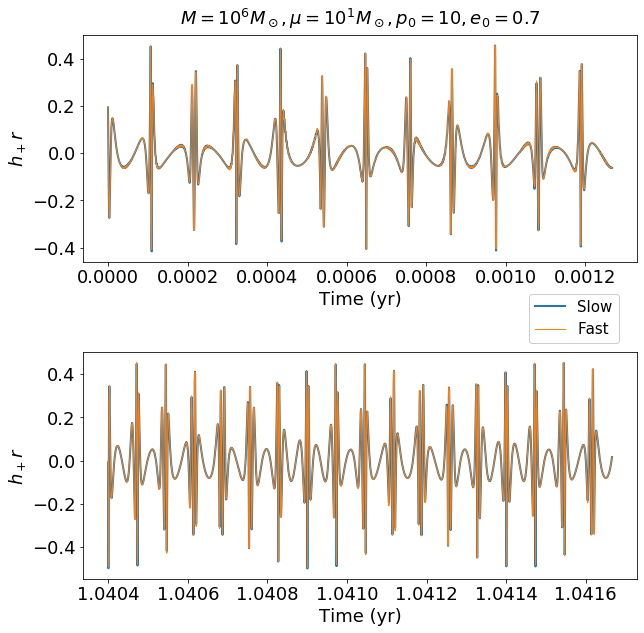

In [101]:
fig, axes = plt.subplots(2,1)
plt.subplots_adjust(hspace=0.4, right=0.85, left=0.15)
fig.set_size_inches(11,10)

num_pts = int(4e3)

starts = np.array([0, wave0.shape[0] - num_pts])
end = starts + num_pts

for i, (st, ed, ax) in enumerate(zip(starts, end, axes)):
    inds = slice(st, ed)
    ax.plot(t[inds]/(365.25*24*3600.0), wave0.real[inds], label='Slow', lw=2)
    ax.plot(t[inds]/(365.25*24*3600.0), wave1.real[inds], label='Fast', lw=1, alpha=1.0)
    ax.set_xlabel('Time (yr)', fontsize=18)
    ax.tick_params(labelsize=18)
    ax.set_ylabel(r'$h_+r$', fontsize=18)

    
axes[0].set_title(r'$M=10^6M_\odot, \mu=10^1M_\odot, p_0=10, e_0=0.7$', pad=10, fontsize=18)
#ax.set_xlabel('time (yr)', fontsize=18)
axes[1].legend(prop={'size': 15}, ncol=1, loc='center right', bbox_to_anchor=[0.98, 1.15], fancybox=True, framealpha=1.0)
fig.savefig('waveform_example.pdf', dpi=200)

In [7]:
wave1.shape

(3155760,)

In [81]:
M = 1e6

p0_arr, e0_arr = np.array([[10., 0.7], [11.48, 0.7], [12.96, 0.7], [14.44, 0.7], [15.92,
  0.7], [17.4, 0.7], [16.2, 0.1], [16.4, 0.2], [16.6, 0.3], [16.8,
  0.4], [17., 0.5], [17.2, 0.6]]).T
mu_arr = np.logspace(0, 3, 1000)

t_end = np.zeros(len(p0_arr))
t_temp = np.zeros(len(mu_arr))
mu_best = np.zeros(len(p0_arr))
for i, (p0, e0) in enumerate(zip(p0_arr, e0_arr)):
    for j, mu in enumerate(mu_arr):
        t, p, e, Phi_phi, Phi_r, flux = traj(M, mu, p0, e0)
        t_temp[j] = t[-1]
        
    ind = np.where(t_temp < 3.15576E+07)[0][0]
    t_end[i] = t_temp[ind]
    mu_best[i] = mu_arr[ind]
            

In [82]:
t_end, mu_best

(array([31527908.15578064, 31482649.20848799, 31460019.69503401,
        31400951.04970514, 31410136.04925216, 31351897.93807325,
        31529250.87709109, 31532447.545115  , 31501138.01156769,
        31552173.9881601 , 31438000.95956628, 31472565.64249278]),
 array([ 14.72882724,  36.69142378,  72.25349492, 125.63166025,
        201.04964163, 304.42722121, 169.1329517 , 179.99285068,
        192.8791508 , 208.122157  , 229.27693129, 257.87628876]))